# Overview

- We will pre-process the data using **Generator** way, and we will explain why we used it
- Then we will explain both ideas **Early_stopping** and **Reduction_learning_rate** and why we used them
- After that, we explained in detail the importance of the idea of **Exponential Decay** and how to implement it
* Compare between**TL Models** and choose the **pest one**
- Then we chose **Xception** to train the model on it
- Finally, we built the neural network, trained it, and checked its accuracy

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam

from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3.1 Get the pathes

In [68]:
train_path = '/content/drive/MyDrive/Dogs vs Cats/train'
test_path = '/content/drive/MyDrive/Dogs vs Cats/test'

### 3.2 Load the Images with a generator and Data Augmentation


 ### Why you should use (flow_from_directory) for Visualize Images ?


 Using `flow_from_directory` in conjunction with `ImageDataGenerator` offers several advantages when working with image datasets in deep learning tasks. Here are some reasons why you might want to use `flow_from_directory`:

1. **Directory Structure and Labels**: If your data is organized in a directory structure where each subdirectory corresponds to a class, `flow_from_directory` can automatically assign labels to images based on the directory names. This eliminates the need for you to manually assign labels to each image.

2. **Data Augmentation**: `ImageDataGenerator` allows you to apply data augmentation techniques such as rotation, flipping, and scaling to your images on-the-fly while they are being loaded. This helps improve the generalization of your model and prevents overfitting.

3. **Batch Loading**: Loading images in batches helps manage memory efficiently, **especially when working with large datasets that may not fit into memory**. `flow_from_directory`loads images in batches, allowing you to train your model with minimal memory usage.

4. **Preprocessing**: `ImageDataGenerator` can apply preprocessing steps such as rescaling pixel values and standardizing input data on-the-fly. This ensures that your input data is properly preprocessed before being fed into the model.

5. **Easy Integration with Keras Models**: The data generator returned by `flow_from_directory` can be directly used as input for Keras' `fit` and `evaluate` methods. This streamlines the training and evaluation process, making it easier to manage data loading and preprocessing.

6. **Shuffling**: By setting the `shuffle` parameter to `True` in `flow_from_directory`, you can shuffle the order of images within each epoch, preventing the model from memorizing the order of training examples.

7. **Efficient Coding**: Using `flow_from_directory` reduces the amount of manual coding required to load and preprocess images, freeing you to focus more on building and training your models.

In [69]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [70]:
images_size = 200
batch_size = 32

In [71]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 557 images belonging to 2 classes.


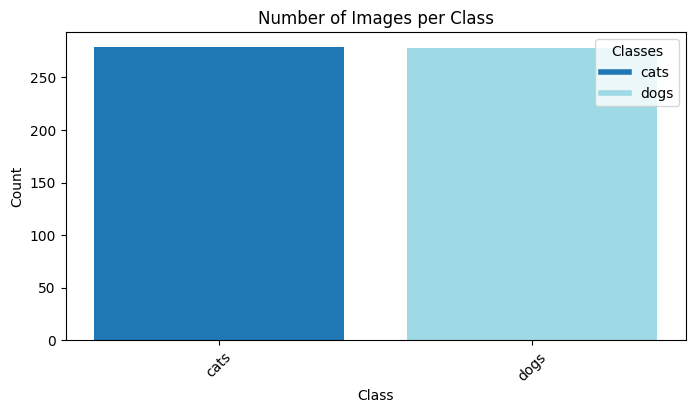

In [72]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [73]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [74]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 140 images belonging to 2 classes.


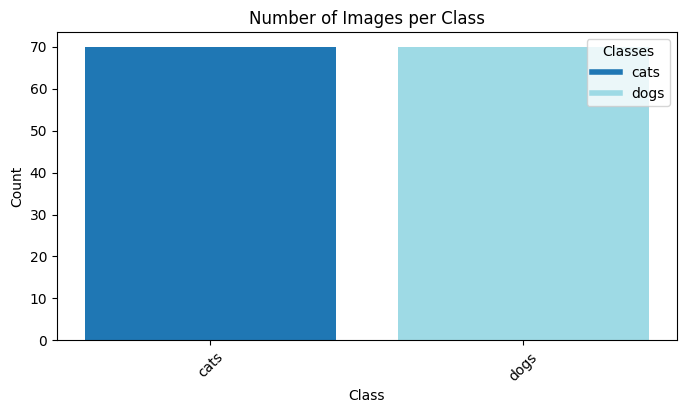

In [75]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

### 3.3 Display Images

In [76]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),16))):
        plt.subplot(4, 4, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

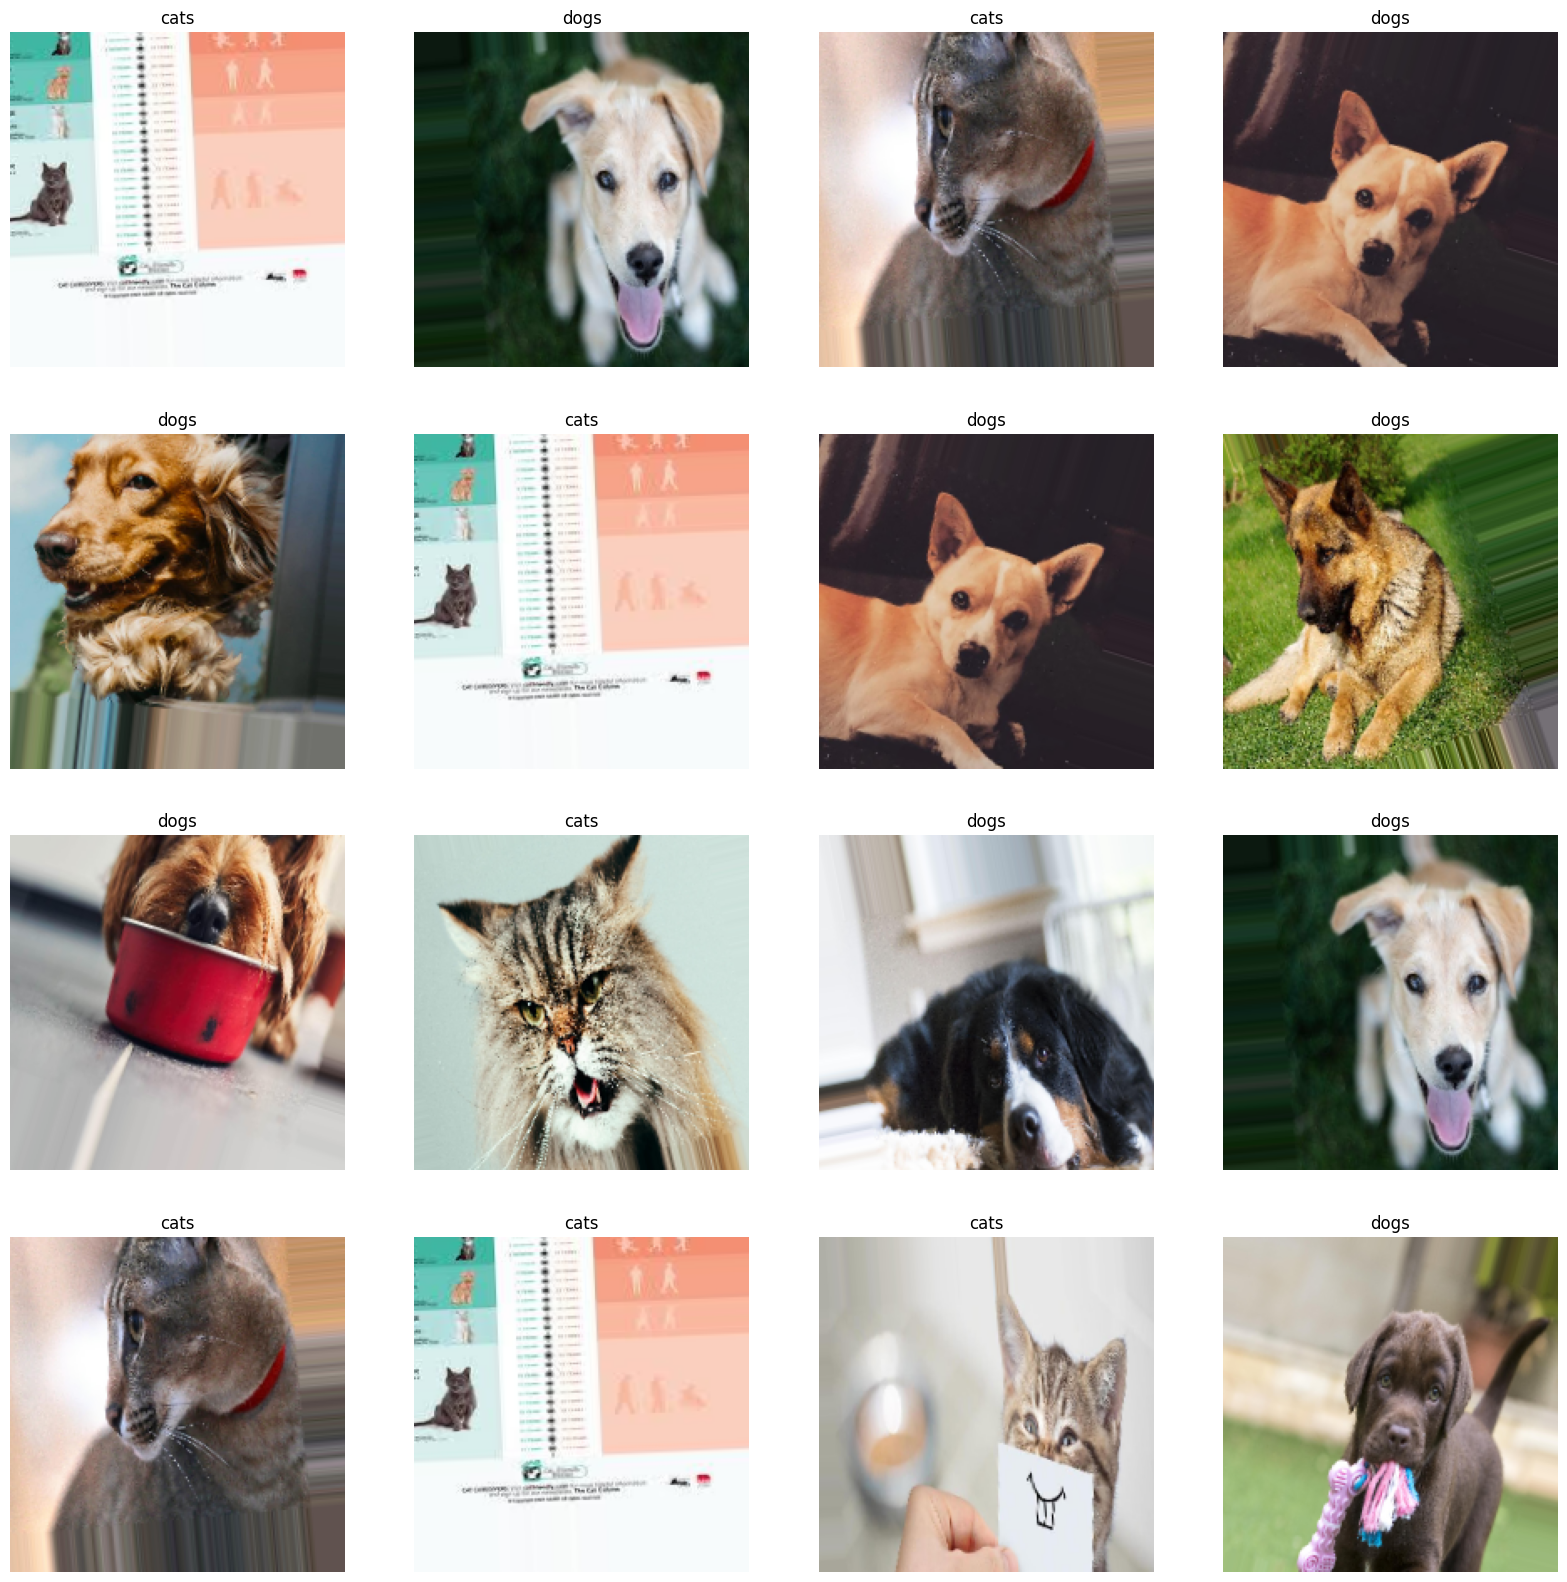

In [77]:
Show_Images(train_generator)

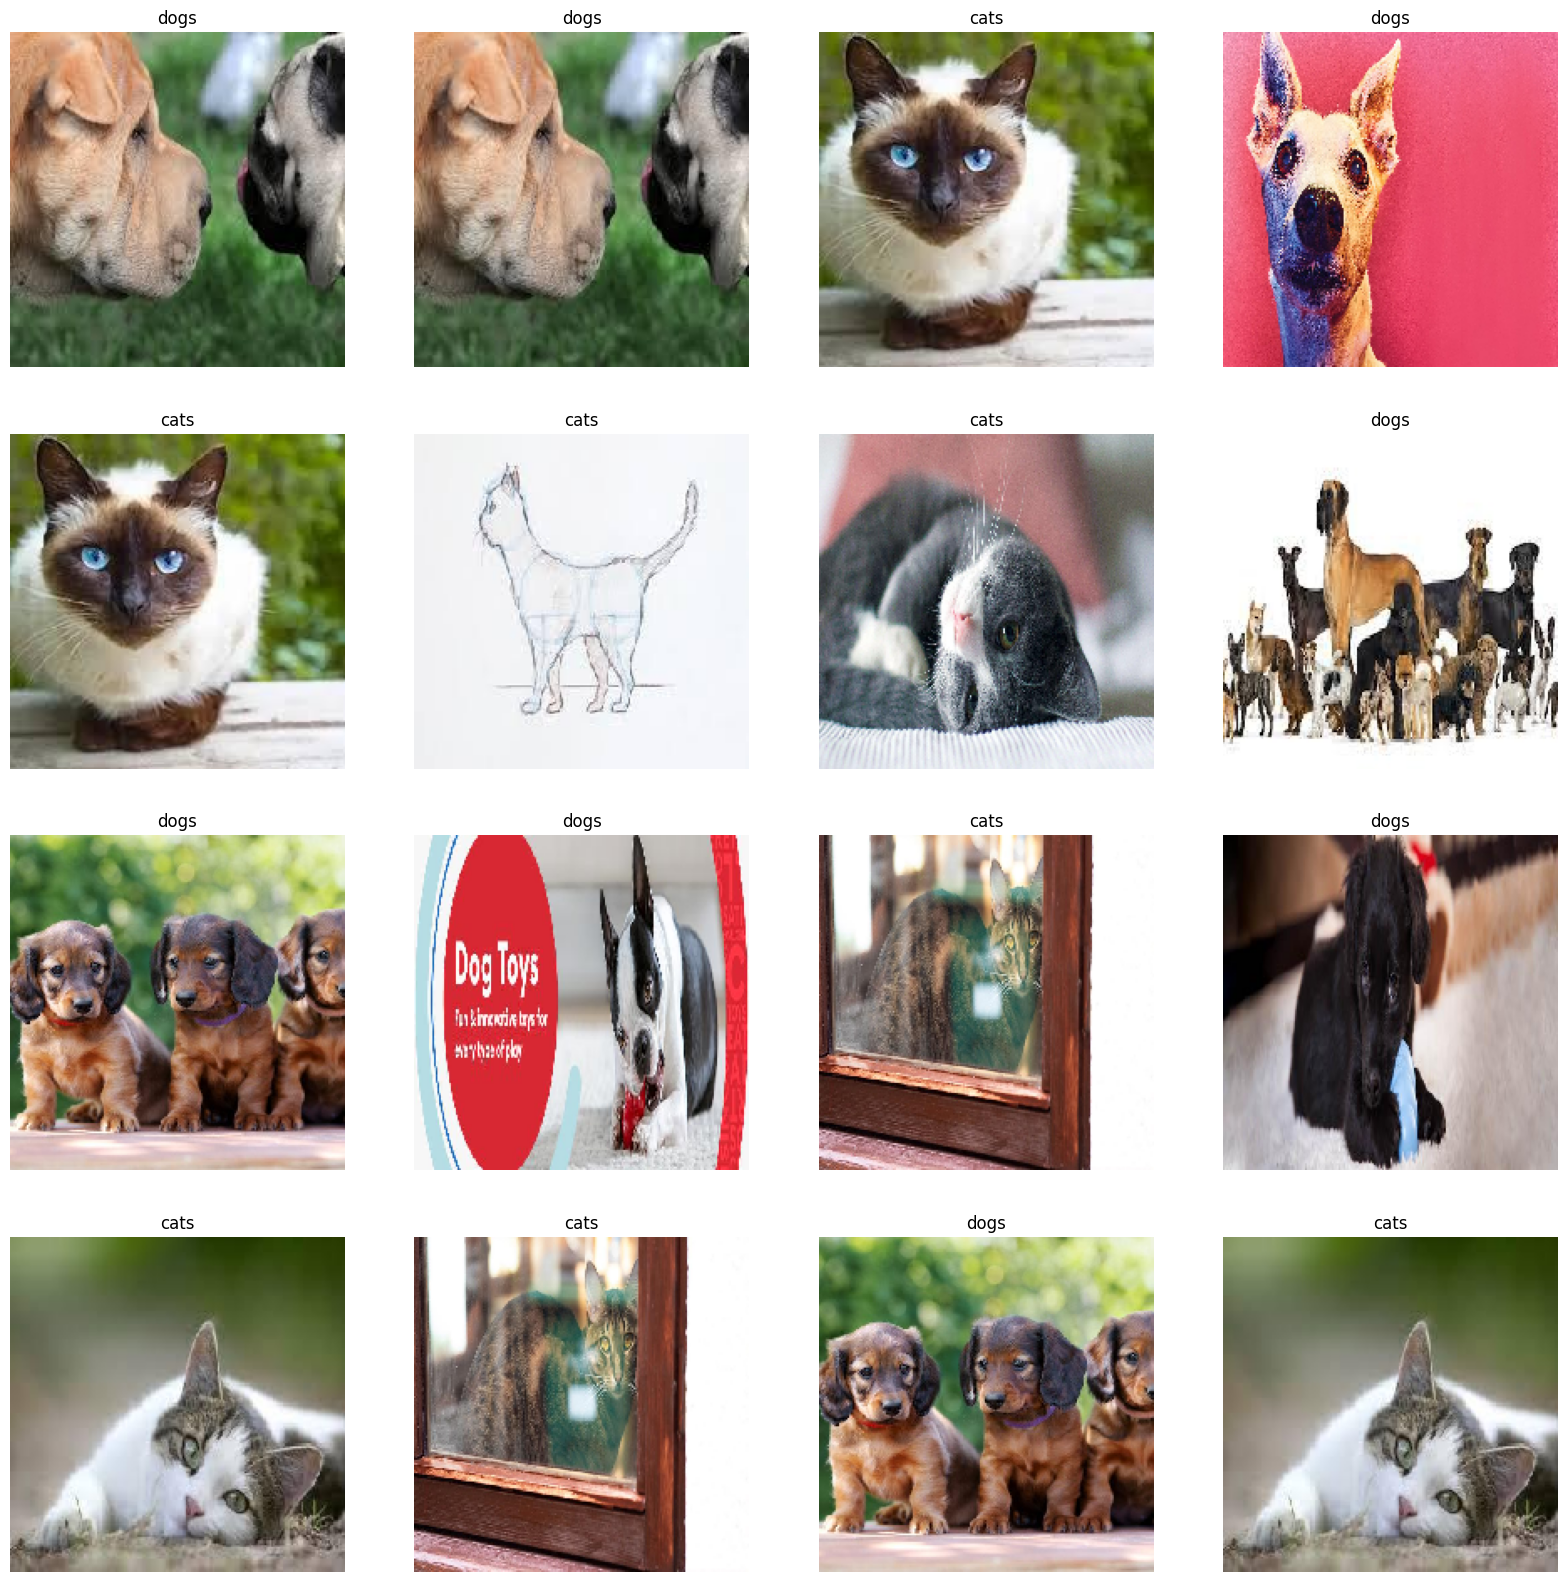

In [78]:
Show_Images(test_generator)

### 3.4 EarlyStopping
***Early stopping*** works by monitoring the performance of the model on a validation set during training. The validation set is a set of data that is held out from the training data and is not used to train the model. The model's performance on the validation set is **used to determine if the model is overfitting.**

If the model's performance on the validation set starts to plateau or decrease, then the training is stopped early. **This prevents the model from continuing to fit the training data too closely**, which can lead to overfitting.



In [79]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

### 3.5 Reduction learning_rate

Reduction of the learning rate means decreasing the step size (learning rate) during training to help a machine learning model converge more effectively and avoid convergence issues.

In [80]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

<a id="section-1"></a>
<h1 style="background-color: #87CEFA; color: #000; text-align: center; border: 2px solid #000; border-radius: 10px; padding: 10px; box-shadow: 5px 5px 5px rgba(0, 0, 0, 0.75); transform: rotateX(10deg);">
  Exponential Decay
</h1>

# 4️⃣.Exponential Decay

📕 ***ExponentialDecay*** is a learning rate schedule that reduces the learning rate exponentially over time. This is done by multiplying the learning rate by a factor of less than 1, such as 0.5 or 0.9, after a certain number of epochs or training steps.

- The formula for exponential decay can be expressed as:

##  ***New Value = Initial Value × Decay Rate ^(Step Count)***


 For example, if you start with an initial learning rate of `0.1` and use an exponential decay rate of `0.9`, the learning rate might evolve as follows:

- After 1 step: \(0.1 \times 0.9^1 = 0.09\)
- After 2 steps: \(0.1 \times 0.9^2 = 0.081\)
- After 3 steps: \(0.1 \times 0.9^3 = 0.0729\)
- ...

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F12053762%2F33e63b666e59d83dc3f11e46f4d04430%2F640px-Plot-exponential-decay.svg.png?generation=1695445033268258&alt=media)

📘 `ExponentialDecay` is a common and effective learning rate schedule **for image classification**. It is often used in conjunction with other techniques, such as momentum and weight decay, **to improve the performance of deep learning models.**

✔️ Here are some of the **benefits** of using `ExponentialDecay`:

* It can help to **prevent overfitting** by reducing the learning rate over time.
* It can help the model to converge **more quickly and smoothly.**
* It can help to **improve the fine-tuning** performance of the model.

❌ However, there are also some **potential drawbacks** to using` ExponentialDecay`:

* It can be **difficult to choose the right initial learning rate and decay rate.**
* It can be **slow to converge in the early stages of training.**

💡 ***Overall***, `ExponentialDecay` is a powerful learning rate schedule that **can be used to improve the performance of deep learning models**. However, **it is important to carefully consider the benefits and drawbacks before using it.**

In [81]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)


In [82]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

<a id="section-1"></a>
<h1 style="background-color: #87CEFA; color: #000; text-align: center; border: 2px solid #000; border-radius: 10px; padding: 10px; box-shadow: 5px 5px 5px rgba(0, 0, 0, 0.75); transform: rotateX(10deg);">
 Compare between TL Models
</h1>

# 5️⃣ Compare between TL Models
<div class="table-of-contents" style="background-color:#87CEFA; padding: 20px; margin: 10px; font-size: 110%; border-radius: 25px; box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);">🔴 In this section, we aim to <b>compare different TL Models architectures to determine which one performs best on our dataset.</b>
    we will first <b>collect a small subset of the data and train a basic model architecture on it</b>.
    then we will <b>analyze the performance of these TL Models and choose the best one ✅</b>.
    </div>

In [83]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    DenseNet121( input_shape=(images_size, images_size, 3) ,weights='imagenet', include_top=False),
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'DenseNet121',
]

# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

### 5.1 Get subset from training data

In [84]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

### 5.2 Training the Models and get Histories

In [85]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):

    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )

    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=10,
        validation_split=0.2,
        batch_size=batch_size
    )

    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
26/26 [==============================] - 92s 3s/step - loss: 0.4337 - accuracy: 0.8918 - val_loss: 0.1223 - val_accuracy: 0.9453
Epoch 2/10
26/26 [==============================] - 89s 3s/step - loss: 0.1966 - accuracy: 0.9378 - val_loss: 0.0876 - val_accuracy: 0.9701
Epoch 3/10
26/26 [==============================] - 89s 3s/step - loss: 0.1966 - accuracy: 0.9577 - val_loss: 0.1005 - val_accuracy: 0.9652
Epoch 4/10
26/26 [==============================] - 89s 3s/step - loss: 0.1240 - accuracy: 0.9639 - val_loss: 0.0923 - val_accuracy: 0.9652
Epoch 5/10
26/26 [==============================] - 90s 3s/step - loss: 0.1174 - accuracy: 0.9652 - val_loss: 0.0752 - val_accuracy: 0.9801
Epoch 6/10
26/26 [==============================] - 94s 4s/step - loss: 0.0755 - accuracy: 0.9789 - val_loss: 0.1282 - val_accuracy: 0.9801
Epoch 7/10
26/26 [==============================] - 90s 3s/step - loss: 0.1276 - accuracy: 0.9751 - val_loss: 0.1153 - val_accuracy: 0.9751
Epoch 8/10
26/26 [==

Training Tl Models:  20%|██        | 1/5 [15:04<1:00:19, 904.82s/it]

Epoch 1/10
26/26 [==============================] - 286s 11s/step - loss: 0.3271 - accuracy: 0.9129 - val_loss: 0.1066 - val_accuracy: 0.9652
Epoch 2/10
26/26 [==============================] - 277s 11s/step - loss: 0.1839 - accuracy: 0.9639 - val_loss: 0.0754 - val_accuracy: 0.9801
Epoch 3/10
26/26 [==============================] - 245s 10s/step - loss: 0.0937 - accuracy: 0.9751 - val_loss: 0.1298 - val_accuracy: 0.9602
Epoch 4/10
26/26 [==============================] - 278s 11s/step - loss: 0.0933 - accuracy: 0.9789 - val_loss: 0.1686 - val_accuracy: 0.9701
Epoch 5/10
26/26 [==============================] - 276s 11s/step - loss: 0.1036 - accuracy: 0.9764 - val_loss: 0.0859 - val_accuracy: 0.9801
Epoch 6/10
26/26 [==============================] - 243s 9s/step - loss: 0.0474 - accuracy: 0.9863 - val_loss: 0.1180 - val_accuracy: 0.9602
Epoch 7/10
26/26 [==============================] - 244s 9s/step - loss: 0.0730 - accuracy: 0.9851 - val_loss: 0.2033 - val_accuracy: 0.9502
Epoch 8/

Training Tl Models:  40%|████      | 2/5 [59:47<1:37:32, 1950.74s/it]

Epoch 1/10
26/26 [==============================] - 56s 2s/step - loss: 0.4837 - accuracy: 0.8682 - val_loss: 0.3108 - val_accuracy: 0.9403
Epoch 2/10
26/26 [==============================] - 62s 2s/step - loss: 0.2832 - accuracy: 0.9303 - val_loss: 0.3175 - val_accuracy: 0.9353
Epoch 3/10
26/26 [==============================] - 62s 2s/step - loss: 0.2721 - accuracy: 0.9565 - val_loss: 0.3626 - val_accuracy: 0.9502
Epoch 4/10
26/26 [==============================] - 51s 2s/step - loss: 0.0977 - accuracy: 0.9751 - val_loss: 0.4905 - val_accuracy: 0.9502
Epoch 5/10
26/26 [==============================] - 63s 2s/step - loss: 0.0841 - accuracy: 0.9751 - val_loss: 0.3215 - val_accuracy: 0.9552
Epoch 6/10
26/26 [==============================] - 62s 2s/step - loss: 0.1001 - accuracy: 0.9813 - val_loss: 0.6141 - val_accuracy: 0.9353
Epoch 7/10
26/26 [==============================] - 52s 2s/step - loss: 0.1458 - accuracy: 0.9652 - val_loss: 0.3760 - val_accuracy: 0.9353
Epoch 8/10
26/26 [==

Training Tl Models:  60%|██████    | 3/5 [1:09:14<43:57, 1318.81s/it]

Epoch 1/10
26/26 [==============================] - 115s 4s/step - loss: 0.3456 - accuracy: 0.8682 - val_loss: 0.3809 - val_accuracy: 0.9005
Epoch 2/10
26/26 [==============================] - 130s 5s/step - loss: 0.0863 - accuracy: 0.9701 - val_loss: 0.1432 - val_accuracy: 0.9652
Epoch 3/10
26/26 [==============================] - 113s 4s/step - loss: 0.0647 - accuracy: 0.9764 - val_loss: 0.1587 - val_accuracy: 0.9502
Epoch 4/10
26/26 [==============================] - 130s 5s/step - loss: 0.0481 - accuracy: 0.9813 - val_loss: 0.1523 - val_accuracy: 0.9502
Epoch 5/10
26/26 [==============================] - 130s 5s/step - loss: 0.0296 - accuracy: 0.9888 - val_loss: 0.1662 - val_accuracy: 0.9502
Epoch 6/10
26/26 [==============================] - 112s 4s/step - loss: 0.0366 - accuracy: 0.9863 - val_loss: 0.1456 - val_accuracy: 0.9552
Epoch 7/10
26/26 [==============================] - 130s 5s/step - loss: 0.0249 - accuracy: 0.9913 - val_loss: 0.1276 - val_accuracy: 0.9701
Epoch 8/10
26

Training Tl Models:  80%|████████  | 4/5 [1:30:08<21:33, 1293.15s/it]

Epoch 1/10
26/26 [==============================] - 89s 3s/step - loss: 0.5998 - accuracy: 0.8085 - val_loss: 0.4809 - val_accuracy: 0.8657
Epoch 2/10
26/26 [==============================] - 82s 3s/step - loss: 0.2361 - accuracy: 0.9403 - val_loss: 0.1303 - val_accuracy: 0.9353
Epoch 3/10
26/26 [==============================] - 77s 3s/step - loss: 0.1584 - accuracy: 0.9478 - val_loss: 0.0709 - val_accuracy: 0.9801
Epoch 4/10
26/26 [==============================] - 82s 3s/step - loss: 0.1608 - accuracy: 0.9403 - val_loss: 0.1607 - val_accuracy: 0.9353
Epoch 5/10
26/26 [==============================] - 82s 3s/step - loss: 0.1376 - accuracy: 0.9540 - val_loss: 0.1317 - val_accuracy: 0.9453
Epoch 6/10
26/26 [==============================] - 75s 3s/step - loss: 0.1426 - accuracy: 0.9502 - val_loss: 0.0786 - val_accuracy: 0.9701
Epoch 7/10
26/26 [==============================] - 82s 3s/step - loss: 0.1432 - accuracy: 0.9565 - val_loss: 0.0592 - val_accuracy: 0.9801
Epoch 8/10
26/26 [==

Training Tl Models: 100%|██████████| 5/5 [1:44:37<00:00, 1255.55s/it]


### 5.3 Analyze the performance of TL Models

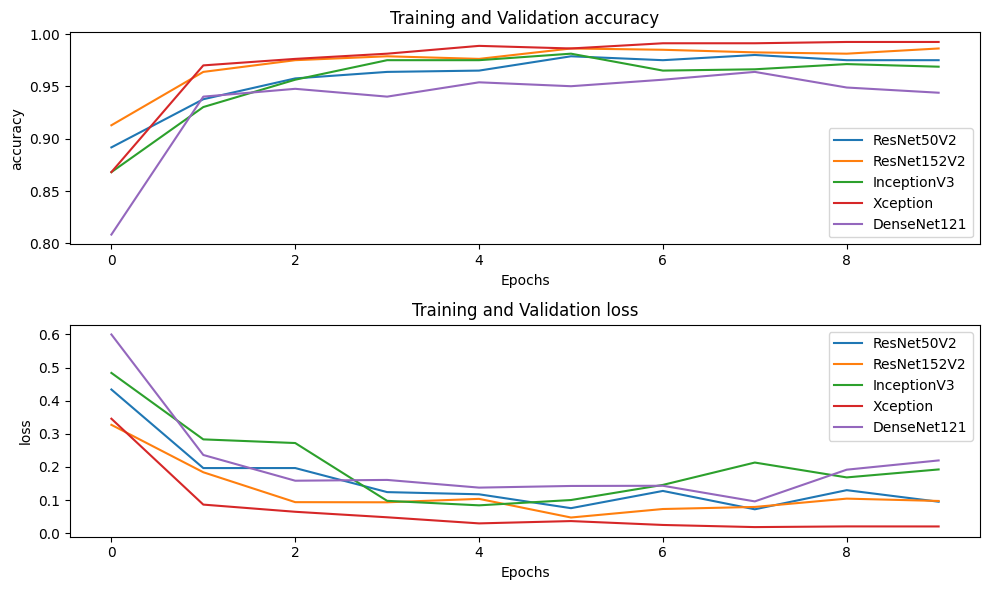

In [86]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

## Note ❗
<div class="table-of-contents" style="background-color:#87CEFA; padding: 20px; margin: 10px; font-size: 110%; border-radius: 25px; box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);">
All training models are <b>similar in performance</b>, but there is a <b>red line that is better than the rest</b>, and it points to <i><b>Xception</b></i>.
So we will select <i><b>Xception</b></i> for traning the model
    </div>

<a id="section-1"></a>
<h1 style="background-color: #87CEFA; color: #000; text-align: center; border: 2px solid #000; border-radius: 10px; padding: 10px; box-shadow: 5px 5px 5px rgba(0, 0, 0, 0.75); transform: rotateX(10deg);">
  Transfer Learning
</h1>

# 6️⃣ Transfer Learning

### 6.1 Get the weights from Xception

In [87]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

### 6.2 Freeze the layers of Xception

In [88]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

<a id="section-1"></a>
<h1 style="background-color: #87CEFA; color: #000; text-align: center; border: 2px solid #000; border-radius: 10px; padding: 10px; box-shadow: 5px 5px 5px rgba(0, 0, 0, 0.75); transform: rotateX(10deg);">
  Build the model
</h1>

# 7️⃣.Build the model

In [89]:
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_13 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 2)                 514       
                                                                 
Total params: 46552362 (177.58 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


### 7.1 Set the optimizer

In [90]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [91]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

### 7.2 Training the model

In [92]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 46.9945 - accuracy: 0.8095

17/17 [==============================] - 91s 5s/step - loss: 46.9945 - accuracy: 0.8095 - val_loss: 12.5458 - val_accuracy: 0.9297 - lr: 0.0099
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 23.5354 - accuracy: 0.9238

17/17 [==============================] - 82s 5s/step - loss: 23.5354 - accuracy: 0.9238 - val_loss: 6.8742 - val_accuracy: 0.9297 - lr: 0.0098
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 8.3450 - accuracy: 0.9505

17/17 [==============================] - 83s 5s/step - loss: 8.3450 - accuracy: 0.9505 - val_loss: 10.7392 - val_accuracy: 0.8906 - lr: 0.0097
Epoch 4/20
17/17 [==============================] - ETA: 0s - loss: 2.6999 - accuracy: 0.9562

17/17 [==============================] - 82s 5s/step - loss: 2.6999 - accuracy: 0.9562 - val_loss: 1.7311 - val_accuracy: 0.9766 - lr: 0.0095
Epoch 5/20
17/17 [==============================] - ETA: 0s - loss: 2.8723 - accuracy: 0.9657

17/17 [==============================] - 88s 5s/step - loss: 2.8723 - accuracy: 0.9657 - val_loss: 1.4284 - val_accuracy: 0.9609 - lr: 0.0094
Epoch 6/20
17/17 [==============================] - ETA: 0s - loss: 1.5445 - accuracy: 0.9676

17/17 [==============================] - 88s 5s/step - loss: 1.5445 - accuracy: 0.9676 - val_loss: 3.2548 - val_accuracy: 0.9219 - lr: 0.0093
Epoch 7/20
17/17 [==============================] - ETA: 0s - loss: 1.7829 - accuracy: 0.9695

17/17 [==============================] - 82s 5s/step - loss: 1.7829 - accuracy: 0.9695 - val_loss: 2.0946 - val_accuracy: 0.9297 - lr: 0.0092
Epoch 8/20
17/17 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.9600

17/17 [==============================] - 83s 5s/step - loss: 0.7100 - accuracy: 0.9600 - val_loss: 0.8730 - val_accuracy: 0.9297 - lr: 0.0091
Epoch 9/20
17/17 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.9581

17/17 [==============================] - 89s 5s/step - loss: 0.9158 - accuracy: 0.9581 - val_loss: 0.4036 - val_accuracy: 0.9375 - lr: 0.0090
Epoch 10/20
17/17 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.9695

17/17 [==============================] - 83s 5s/step - loss: 0.5724 - accuracy: 0.9695 - val_loss: 0.9921 - val_accuracy: 0.9062 - lr: 0.0089
Epoch 11/20
17/17 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.9543

17/17 [==============================] - 82s 5s/step - loss: 0.5954 - accuracy: 0.9543 - val_loss: 0.4493 - val_accuracy: 0.9219 - lr: 0.0088
Epoch 12/20
17/17 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.9581

17/17 [==============================] - 84s 5s/step - loss: 0.7285 - accuracy: 0.9581 - val_loss: 0.3342 - val_accuracy: 0.9453 - lr: 0.0087
Epoch 13/20
17/17 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.9600

17/17 [==============================] - 88s 5s/step - loss: 0.3471 - accuracy: 0.9600 - val_loss: 0.2442 - val_accuracy: 0.9609 - lr: 0.0086
Epoch 14/20
17/17 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.9771

17/17 [==============================] - 88s 5s/step - loss: 0.3384 - accuracy: 0.9771 - val_loss: 0.2741 - val_accuracy: 0.9453 - lr: 0.0085
Epoch 15/20
17/17 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.9695

17/17 [==============================] - 84s 5s/step - loss: 0.4089 - accuracy: 0.9695 - val_loss: 0.2408 - val_accuracy: 0.9453 - lr: 0.0084
Epoch 16/20
17/17 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9706

17/17 [==============================] - 86s 5s/step - loss: 0.1694 - accuracy: 0.9706 - val_loss: 0.1929 - val_accuracy: 0.9609 - lr: 0.0083
Epoch 17/20
17/17 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9733

17/17 [==============================] - 88s 5s/step - loss: 0.2092 - accuracy: 0.9733 - val_loss: 0.2576 - val_accuracy: 0.9297 - lr: 0.0082
Epoch 18/20
17/17 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9752

17/17 [==============================] - 84s 5s/step - loss: 0.1242 - accuracy: 0.9752 - val_loss: 0.2005 - val_accuracy: 0.9531 - lr: 0.0081
Epoch 19/20
17/17 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9695

17/17 [==============================] - 88s 5s/step - loss: 0.0811 - accuracy: 0.9695 - val_loss: 0.2087 - val_accuracy: 0.9609 - lr: 0.0080
Epoch 20/20
17/17 [==============================] - ETA: 0s - loss: 1.1835 - accuracy: 0.9410

17/17 [==============================] - 82s 5s/step - loss: 1.1835 - accuracy: 0.9410 - val_loss: 0.1455 - val_accuracy: 0.9375 - lr: 0.0079


<a id="section-1"></a>
<h1 style="background-color: #87CEFA; color: #000; text-align: center; border: 2px solid #000; border-radius: 10px; padding: 10px; box-shadow: 5px 5px 5px rgba(0, 0, 0, 0.75); transform: rotateX(10deg);">
  Evaluate the model
</h1>

# 8️⃣. Evaluate the model

### 8.1 Evaluate the validation

In [93]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2261456847190857
Test accuracy: 0.9285714030265808


### 8.4 Confusion Matrix

5/5 [==============================] - 18s 3s/step


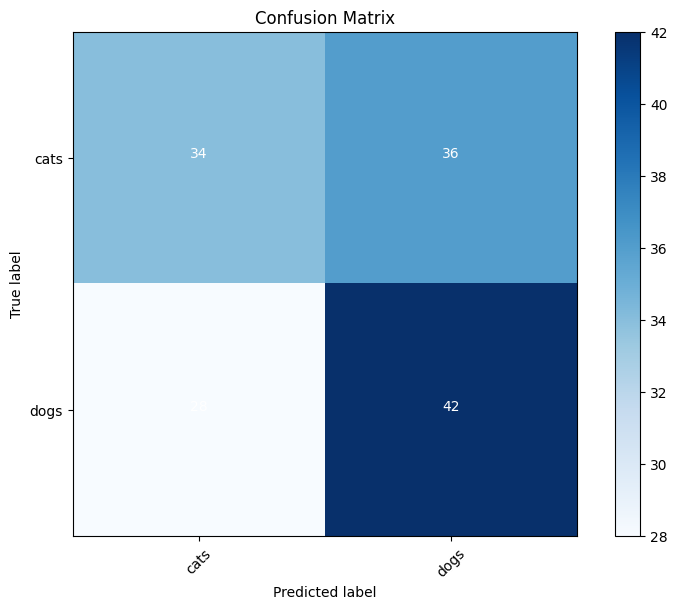

In [97]:
# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()


### 8.5 Generate predictions for the test data

1/1 [==============================] - 1s 1s/step


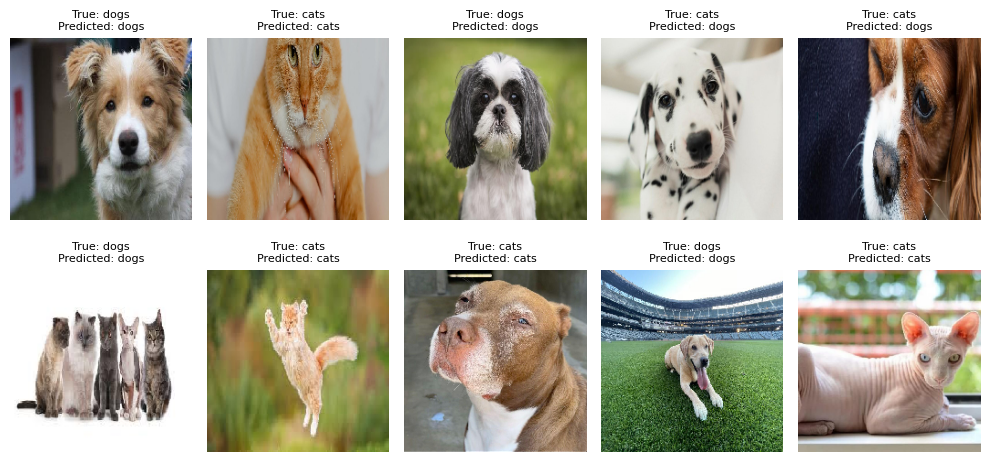

In [100]:
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()
class_names = list(class_names)
num_batches = len(test_generator)
for i in range(5):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()